![tutorial banner](https://github.com/PV-Tutorials/2025_pvlib_pvsc/blob/main/static/pvlib_pvsc_logo.png?raw=true)

# PART 2-  PV Systems Modeling with Python

Welcome to the 2025 PVSC tutorial on **PV Systems modeling with Python**. This tutorial will give an interactive introduction to how to model photovoltaic (PV) system energy yield using the open-source software [pvlib-python](https://pvlib-python.readthedocs.io/).

It is recommended to first complete Part 1 of the tutorial, which gives an introduction to Google Colab and how to retrieve irradiance data using pvlib. Part 1 can be found [here](https://colab.research.google.com/github/PV-Tutorials/2025_pvlib_pvsc/blob/main/pvlib-introduction-part-1.ipynb).

We will be modeling the energy yield of a single-axis tracking (SAT) with bifacial modules. The specific plant is a 465 MW plant in Alberta, Canada called the [Travers Solar Project](https://en.wikipedia.org/wiki/Travers_Solar_Project).

![Travers Solar Power Plant](https://www.cip.com/media/j33jqebc/misae-usa_06.jpg?width=2592&height=1296&rnd=133467632437370000)
_Credit: Copenhagen Infrastructure Partners [3]._

The following parameters have been estimated based on freely available data online or estimated:

**General information**
- Coordinates [1]: 50.267, -112.718
- Project life [2]: 35+ years

**Plant layout and configuration**
* Mounting: single-axis trackers
* Tracking axis: north-south (0 degrees)
* Module configuration: one-in-portrait (1P)
* Max rotation: 55 degrees (_estimate_)
* Pitch [2]: 6.67m
* Torque tube height: 1.8 m (_estimate_)

**Modules**
* Total capacity [3]: 691 MWdc
* No. of modules [3]: approx. 1,300,000
* Module nameplate capacity: ~530W
* Technology [4]: bifacial monocrystalline
* Manufacturer [4]: Jinko
* Module model : [datasheet (_example_)](https://www.starworld-tech.com/half-cell-solar-panel/jinko-tiger-pro-bifacial-530-550w-.html)
* Bifaciality: 70% (_estimate_)

**Inverters**
* Total output [3]: 465 MWac
* Number of inverters [2]: 153
* Inverter type: central

## References
- [1] https://en.wikipedia.org/wiki/Travers_Solar_Project
- [2] https://www.traverssolar.ca/ (Oct. 2020 Project Map and Feb. 2019 Open House Boards)
- [3] https://www.cip.com/approach/our-projects/travers/
- [4] https://www.power-technology.com/projects/travers-solar-project-alberta-canada.

## Step 1: Install pvlib

First, we need to get pvlib installed in the Colab environment.  Select the code cell below (left click) and execute it (shift+enter) to automatically download and install pvlib:

In [ ]:
!pip install pvlib==0.13.0

In [1]:
# Import libraries
import pvlib
import pandas as pd
import matplotlib.pyplot as plt

## Step 2: Irradiance data
This step was covered in Part 1 of the tutorial. You may copy your code from Part 1 or use the code below.

In [5]:
location = pvlib.location.Location(latitude=50.267, longitude=-112.718)

data, meta = pvlib.iotools.get_pvgis_tmy(
    location.latitude, location.longitude)

data.index = data.index + pd.Timedelta(minutes=30)

data.head()

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
time(UTC),,,,,,,,,
2007-01-01 00:30:00+00:00,-8.40,57.80,0.0,0.0,0.0,191.29,2.13,218.0,91470.0
2007-01-01 01:30:00+00:00,-8.04,58.36,0.0,0.0,0.0,194.68,2.12,278.0,91450.0
2007-01-01 02:30:00+00:00,-7.69,58.93,0.0,0.0,0.0,198.08,2.12,286.0,91460.0
2007-01-01 03:30:00+00:00,-7.33,59.49,0.0,0.0,0.0,201.47,2.11,281.0,91470.0
2007-01-01 04:30:00+00:00,-6.98,60.05,0.0,0.0,0.0,204.87,2.11,278.0,91470.0


## Step 3: Calculate solar position
This step was covered in Part 1 of the tutorial. You may copy your code from Part 1 or use the code below.


In [6]:
# Write your code here to calculate solar position
solar_position = location.get_solarposition(data.index)

solar_position.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
time(UTC),,,,,,
2007-01-01 00:30:00+00:00,97.979425,97.979425,-7.979425,-7.979425,243.263202,-3.200686
2007-01-01 01:30:00+00:00,106.892451,106.892451,-16.892451,-16.892451,254.054390,-3.220417
2007-01-01 02:30:00+00:00,116.299020,116.299020,-26.299020,-26.299020,264.922853,-3.240140
2007-01-01 03:30:00+00:00,125.864436,125.864436,-35.864436,-35.864436,276.558858,-3.259853
2007-01-01 04:30:00+00:00,135.177002,135.177002,-45.177002,-45.177002,290.003573,-3.279557


## Step 4: Calculate tracker orientations

The next step is to determine the orientation (rotation) of the single-axis trackers as this influences the incident irradiance.

The orientation of a single-axis tracker can be calculated using the [``pvlib.tracking.singleaxis``](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.tracking.singleaxis.html) function.

You may assume that the tracking axis has the typical orientation of north-south, which corresponds to ``axis_azimuth=0``. Also, we will assume that the SAT features backtracking and has a maximum tracker rotation angle of 55 degrees.

Last, you may notice that the ground coverage ratio (GCR) is also needed but hasn't been provided. This dimensionless ratio can be calculated by dividing the module length (given that it is a 1P configuration) by the pitch (row-to-row distance).

In [ ]:
max_tracker_angle = 55  # [degrees]
pitch = 6.67  # [m] center-to-center tracker spacing in the horizontal dimension
module_length =  # [m] from datasheet
gcr = 

# calculate tracker rotations for a single-axis tracker
tracker_orientations = 

# Print five first non-nan rows
tracker_orientations.dropna().head()

## Step 5: Calculate plane of array irradiance
The irradiance data we obtained from PVGIS contains the three standard components:
- global horizontal irradiance (GHI)
- diffuse horizontal irradiance (DHI)
- direct normal irradiance (DNI)

However, to determine PV generation, we need to know the incident irradiance on the module surface, which is denoted as plane of array (POA) irradiance. Additionally, since we are working with bifacial modules, we need to estimate both the front and rear-side POA irradiance.

To do this, we will be using pvlib's [infinite sheds bifacial model](https://pvlib-python.readthedocs.io/en/stable/user_guide/bifacial.html#infinite-sheds) which is based on view factors and assumes the PV system comprises of parallel, evenly spaced rows on a level, horizontal surface. The function is called [``pvlib.bifacial.infinite_sheds.get_irradiance``](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.bifacial.infinite_sheds.get_irradiance.html).

**Can you use the infinite sheds model to calculate front and rear side irradiance?** Remember you have determined the tracker orientation in the previous step.

In [ ]:
# Write your code here to calculate plane of array irradiance

dni_extra = pvlib.irradiance.get_extra_radiation(data.index)

front_rear_irradiance = pvlib.bifacial.infinite_sheds.get_irradiance(
    # fill in all the necessary inputs
    #
    #
    #
)

# Print five first non-nan rows
front_rear_irradiance.dropna().head()

## Step 6: Calculate module temperature

The power efficiency of a PV module depends on its temperature (roughly, a 0.4% decrease in power for every increase in degrees C).  Module temperature can be estimated based on ambient temperature, POA irradiance, and wind speed.

pvlib includes several models for estimating module temperature. Can you find one in the documentation?

In [7]:
# Write your code here to calculate module temperature using a model of your choosing
module_temperature = 


## Step 7: Calculate DC PV power

With the plane of array irradiance and module temperature ready, we can now estimate the PV output power.  There are several modeling approaches available here, including:

* Simple efficiency (like in PVWatts)
* Single-diode models, like in PVsyst and SAM
* Empirical methods like the SAPM

Each type of these PV models requires different types of parameters.  They all produce estimates of the maximum power point (MPP), while the fancier ones also estimate other quantities like open circuit voltage and short circuit current.

The simplest option is to use [``pvlib.pvsystem.pvwatts_dc``](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.pvsystem.pvwatts_dc.html).  Can you use it with the POA irradiance and module temperature to estimate the output power for one module?

*Note: for this exercise you may assume that the module and cell temperature are the same.*

<Axes: >

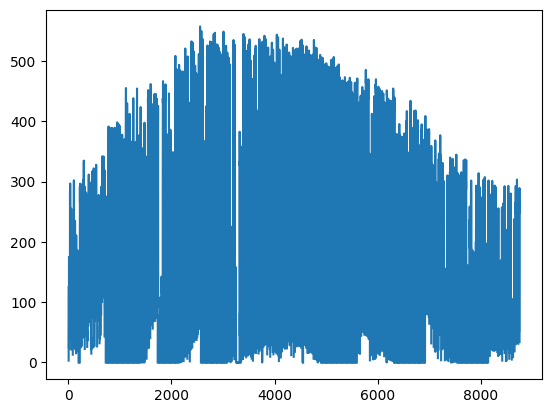

In [11]:
pdc0 = # [W] Nominal power at STC
gamma_pdc = -0.003  # [%/degC] Pmax temperature coefficient

# Write your code here to calculate PV power
dc_power = 


dc_power.plot() # plot results

## Step 8: Reflect on the exercise

We managed to model the output of one panel, how do you think we can extend the model workflow to simulate a full system?

Last, this exercise made a number of simplifications. Can you name some? How do you think the accuracy was affected?

[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).